In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install haversine > /dev/null
!python3 -m pip install geopandas > /dev/null

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def to_float (s) :
   return float(s.replace(',','.'))

float_udf = udf(to_float , FloatType())

#Task 1

In [5]:
df = spark.read.option("header",True).csv("./countries of the world.csv")
df = df.select('Literacy (%)', 'GDP ($ per capita)', 'Infant mortality (per 1000 births)').na.drop()
df = df.withColumn("Literacy (%)", float_udf("Literacy (%)")).withColumn("GDP ($ per capita)", float_udf("GDP ($ per capita)")).withColumn("Infant mortality (per 1000 births)", float_udf("Infant mortality (per 1000 births)"))

In [ ]:
df = df.sort(['GDP ($ per capita)'])

In [ ]:
poorest_df = spark.createDataFrame(df.head(30))
richest_df = spark.createDataFrame(df.tail(30))

In [ ]:
poorest_df.show()

+------------------+------------------+----------------------------------+
|      Literacy (%)|GDP ($ per capita)|Infant mortality (per 1000 births)|
+------------------+------------------+----------------------------------+
|31.399999618530273|             500.0|                143.63999938964844|
|58.599998474121094|             500.0|                 47.40999984741211|
| 37.79999923706055|             500.0|                116.69999694824219|
| 62.70000076293945|             600.0|                103.31999969482422|
|51.599998474121094|             600.0|                 69.29000091552734|
| 78.19999694824219|             600.0|                 98.54000091552734|
|              56.5|             700.0|                 74.93000030517578|
|              65.5|             700.0|                 94.69000244140625|
| 83.80000305175781|             700.0|                 93.86000061035156|
|58.599998474121094|             700.0|                 74.87000274658203|
| 42.70000076293945|     

In [ ]:
richest_df.show()

+----------------+------------------+----------------------------------+
|    Literacy (%)|GDP ($ per capita)|Infant mortality (per 1000 births)|
+----------------+------------------+----------------------------------+
|97.9000015258789|           22000.0|                 4.420000076293945|
|77.9000015258789|           23200.0|                14.510000228881836|
|96.0999984741211|           23400.0|                 6.400000095367432|
|            92.5|           23700.0|                2.2899999618530273|
|           100.0|           25000.0|                 4.699999809265137|
|98.5999984741211|           26700.0|                 5.940000057220459|
|            99.0|           26800.0|                2.7699999809265137|
|            99.0|           27000.0|                 5.429999828338623|
|           100.0|           27400.0|                 3.569999933242798|
|            99.0|           27600.0|                 4.260000228881836|
|            99.0|           27600.0|              

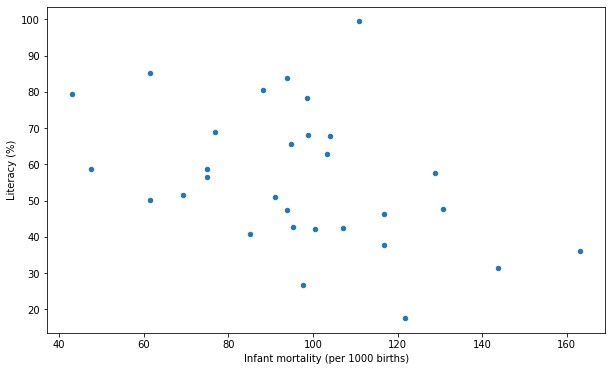

In [ ]:
poorest_df.toPandas().plot(x="Infant mortality (per 1000 births)",y="Literacy (%)",kind="scatter",figsize=(10, 6))

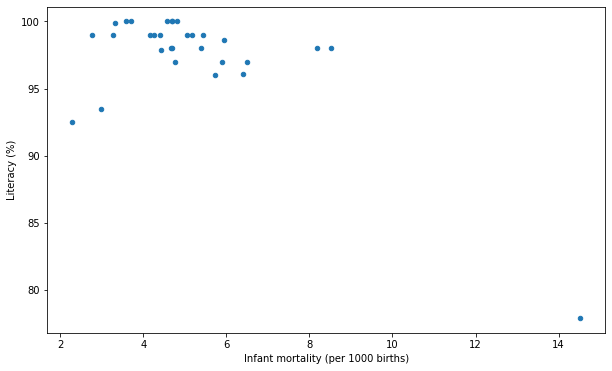

In [ ]:
richest_df.toPandas().plot(x="Infant mortality (per 1000 births)",y="Literacy (%)",kind="scatter",figsize=(10, 6))

#Task 2

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyspark.sql.types import StructType, StructField, IntegerType, StringType


In [7]:
schema = StructType([
    StructField("airport_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True),
    StructField("iata", StringType(), True),
    StructField("icao", StringType(), True),
    StructField("latitude", FloatType(), True),
    StructField("longitude", FloatType(), True),
    StructField("altitude", FloatType(), True),
    StructField("timezone", IntegerType(), True),
    StructField("dst", StringType(), True),
    StructField("tz_database", StringType(), True),
    StructField("type", StringType(), True),
    StructField("source", StringType(), True)])

airports_df = spark.read.csv("./airports.csv",header=False,schema=schema)
airports_df.show()


+----------+--------------------+--------------+----------------+----+----+---------+----------+--------+--------+---+--------------------+-------+-----------+
|airport_id|                name|          city|         country|iata|icao| latitude| longitude|altitude|timezone|dst|         tz_database|   type|     source|
+----------+--------------------+--------------+----------------+----+----+---------+----------+--------+--------+---+--------------------+-------+-----------+
|         1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA| -6.08169|   145.392|  5282.0|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD| -5.20708|   145.789|    20.0|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH| -5.82679|   144.296|  5388.0|      10|  U|Pacific/Port_Moresby|airport|OurAirports|
|         4|      Nadzab Airport|       

In [ ]:
airports_gdf = gpd.GeoDataFrame(
    airports_df.toPandas(), geometry=gpd.points_from_xy(airports_df.toPandas()["longitude"], airports_df.toPandas()["latitude"]))
airports_gdf.head()

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_database,type,source,geometry
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282.0,10.0,U,Pacific/Port_Moresby,airport,OurAirports,POINT (145.39200 -6.08169)
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20.0,10.0,U,Pacific/Port_Moresby,airport,OurAirports,POINT (145.78900 -5.20708)
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388.0,10.0,U,Pacific/Port_Moresby,airport,OurAirports,POINT (144.29601 -5.82679)
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725983,239.0,10.0,U,Pacific/Port_Moresby,airport,OurAirports,POINT (146.72598 -6.56980)
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146.0,10.0,U,Pacific/Port_Moresby,airport,OurAirports,POINT (147.22000 -9.44338)


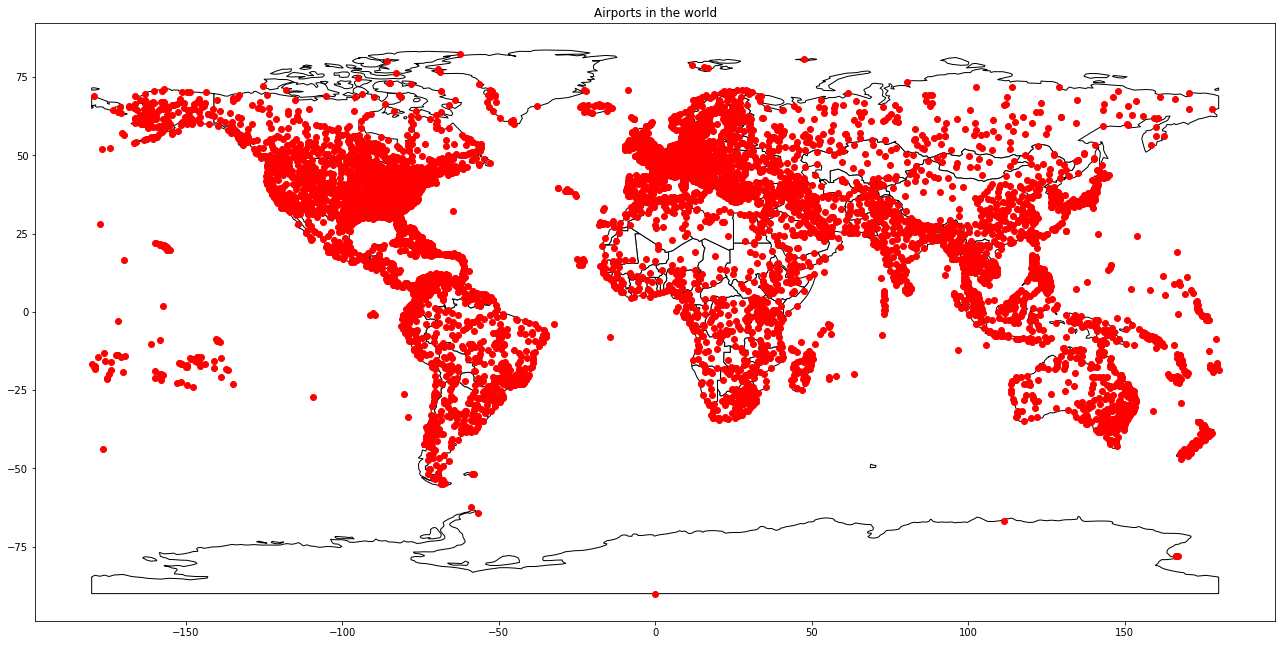

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black',figsize=(24, 11))
ax.set_title("Airports in the world")

airports_gdf.plot(ax=ax, color='red')

plt.show()

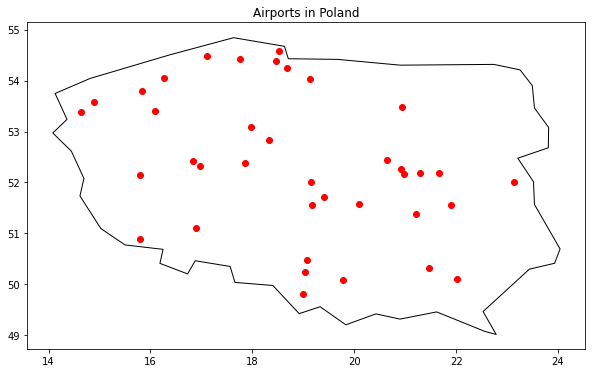

In [ ]:
poland_airports_gdf = airports_gdf[airports_gdf['country'] == 'Poland']

ax = world[world.name == 'Poland'].plot(
    color='white', edgecolor='black',figsize=(10, 10))
ax.set_title("Airports in Poland")

poland_airports_gdf.plot(ax=ax, color='red')

plt.show()

#Task 3

In [8]:
from haversine import haversine, Unit
from pyspark.sql.types import StructType,StructField, StringType
from pyspark.sql.functions import col,lit,min,first

In [ ]:
south_pole_coord = (-90.0, 0)

In [ ]:
calculate_dist = udf(lambda col1, col2 : haversine(south_pole_coord, (col1, col2)), FloatType())

In [ ]:
airports_df_with_distance = airports_df.select("airport_id", "name", "country", "latitude", "longitude")
airports_df_with_distance = airports_df_with_distance.withColumn('dist',calculate_dist(col("latitude"), col("longitude")))
min_dist_df = airports_df_with_distance.groupBy("country").agg(min("dist").alias("min_dist")).withColumnRenamed("country", "country_a")
nearest_airport_per_country_df = airports_df_with_distance.join(min_dist_df, airports_df_with_distance.dist == min_dist_df.min_dist, "inner").select("name", "country_a", "min_dist", "latitude", "longitude").sort("country_a").dropDuplicates(["country_a"])
nearest_airport_per_country_df.show()

+--------------------+-------------------+---------+---------+---------+
|                name|          country_a| min_dist| latitude|longitude|
+--------------------+-------------------+---------+---------+---------+
|      Zaranj Airport|        Afghanistan|13451.516|30.972221|61.865833|
|      Vlorë Air Base|            Albania|14508.301|  40.4761|  19.4742|
|Bordj Badji Mokht...|            Algeria|12384.353|   21.375| 0.923889|
|Pago Pago Interna...|     American Samoa|8414.0205|  -14.331|  -170.71|
|Ngjiva Pereira Ai...|             Angola| 8112.404| -17.0435|  15.6838|
|   Wallblake Airport|           Anguilla|12031.842|  18.2048| -63.0551|
|South Pole Statio...|         Antarctica|      0.0|    -90.0|      0.0|
|V.C. Bird Interna...|Antigua and Barbuda|11913.074|  17.1367| -61.7927|
|Malvinas Argentin...|          Argentina|3909.2522| -54.8433| -68.2958|
|    Dzhermuk Airport|            Armenia| 14435.79|   39.824|   45.674|
|Queen Beatrix Int...|              Aruba|11397.651

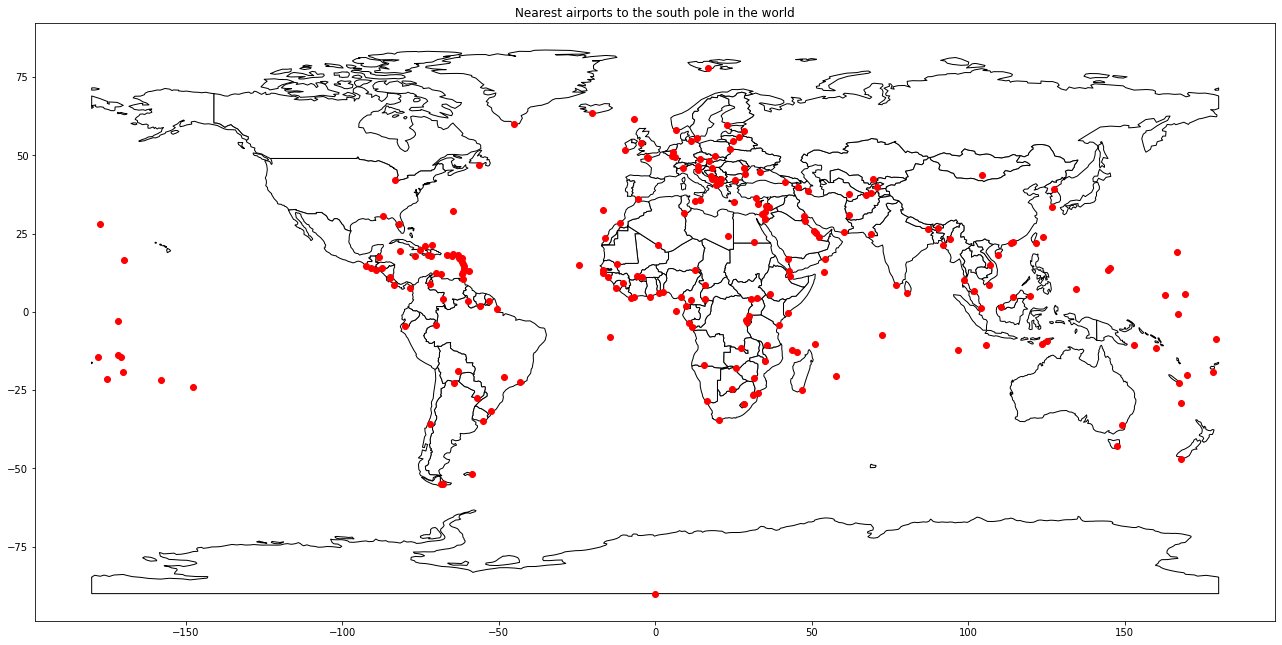

In [ ]:
nearest_airport_per_country_gdf = gpd.GeoDataFrame(
    nearest_airport_per_country_df.toPandas(), geometry=gpd.points_from_xy(nearest_airport_per_country_df.toPandas()["longitude"], nearest_airport_per_country_df.toPandas()["latitude"]))
nearest_airport_per_country_gdf.head()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black',figsize=(24, 11))
ax.set_title("Nearest airports to the south pole in the world")

nearest_airport_per_country_gdf.plot(ax=ax, color='red')

plt.show()

#Task 4

In [9]:
from pyspark.sql.functions import regexp_replace, col

In [10]:
spaceDeleteUDF = udf(lambda s: s.rstrip(), StringType())

In [11]:
df_countries = spark.read.option("header",True).csv("./countries of the world.csv").withColumnRenamed("Area (sq. mi.)", "Area sq mi").withColumnRenamed("Pop. Density (per sq. mi.)", "Pop density per sq mi")
df_countries = df_countries.withColumn("Country", spaceDeleteUDF("Country"))

In [12]:
airports_count_df = airports_df.groupBy("country").count().withColumnRenamed("country", "country_a").sort("country_a")
airports_count_df.show()

+-------------------+-----+
|          country_a|count|
+-------------------+-----+
|        Afghanistan|   20|
|            Albania|    5|
|            Algeria|   43|
|     American Samoa|    2|
|             Angola|   24|
|           Anguilla|    1|
|         Antarctica|    7|
|Antigua and Barbuda|    2|
|          Argentina|   94|
|            Armenia|    5|
|              Aruba|    1|
|          Australia|  296|
|            Austria|   19|
|         Azerbaijan|    7|
|            Bahamas|   33|
|            Bahrain|    2|
|         Bangladesh|   10|
|           Barbados|    1|
|            Belarus|   10|
|            Belgium|   24|
+-------------------+-----+
only showing top 20 rows



In [13]:
joined_df = airports_count_df.join(df_countries, airports_count_df.country_a == df_countries.Country, "inner").drop("country_a")
joined_df.show()

+-----+-----------+--------------------+----------+----------+---------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|count|    Country|              Region|Population|Area sq mi|Pop density per sq mi|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+-----+-----------+--------------------+----------+----------+---------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|    6|       Chad|SUB-SAHARAN AFRIC...|   9944201|   1284000|                  7,7|             

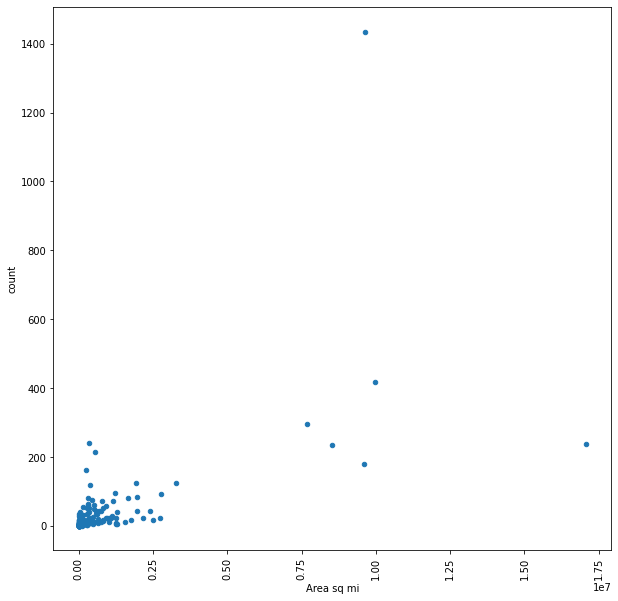

In [14]:
joined_df_float = joined_df.withColumn('Area sq mi', float_udf('Area sq mi'))
joined_df_float.sort("Area sq mi").toPandas().plot(x="Area sq mi",y="count",kind="scatter",figsize=(10, 10))
plt.xticks(fontsize=10, rotation='vertical');

In [ ]:
joined_null_df = df_countries.join(airports_count_df, airports_count_df.country_a == df_countries.Country, "anti")
joined_null_df.show()

+--------------------+--------------------+----------+----------+---------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|             Country|              Region|Population|Area sq mi|Pop density per sq mi|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+--------------------+--------------------+----------+----------+---------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|             Andorra|WESTERN EUROPE   ...|     71201|       468|                152,1| 

#Task 5

In [ ]:
from pyspark.sql.functions import sum as _sum


In [ ]:
joined_df = airports_count_df.join(df_countries, airports_count_df.country_a == df_countries.Country, "inner").withColumn("count", airports_count_df["count"].cast("int")).drop("country_a")
count_by_region_df = joined_df.groupBy("Region").agg(_sum("count").alias("count"))
count_by_region_df.show()


+--------------------+-----+
|              Region|count|
+--------------------+-----+
|BALTICS          ...|   24|
|C.W. OF IND. STATES |  357|
|ASIA (EX. NEAR EA...| 1064|
|WESTERN EUROPE   ...| 1224|
|NORTHERN AMERICA ...| 1875|
|NEAR EAST        ...|  208|
|EASTERN EUROPE   ...|  143|
|OCEANIA          ...|  542|
|SUB-SAHARAN AFRIC...|  534|
|NORTHERN AFRICA  ...|  121|
|LATIN AMER. & CAR...|  921|
+--------------------+-----+



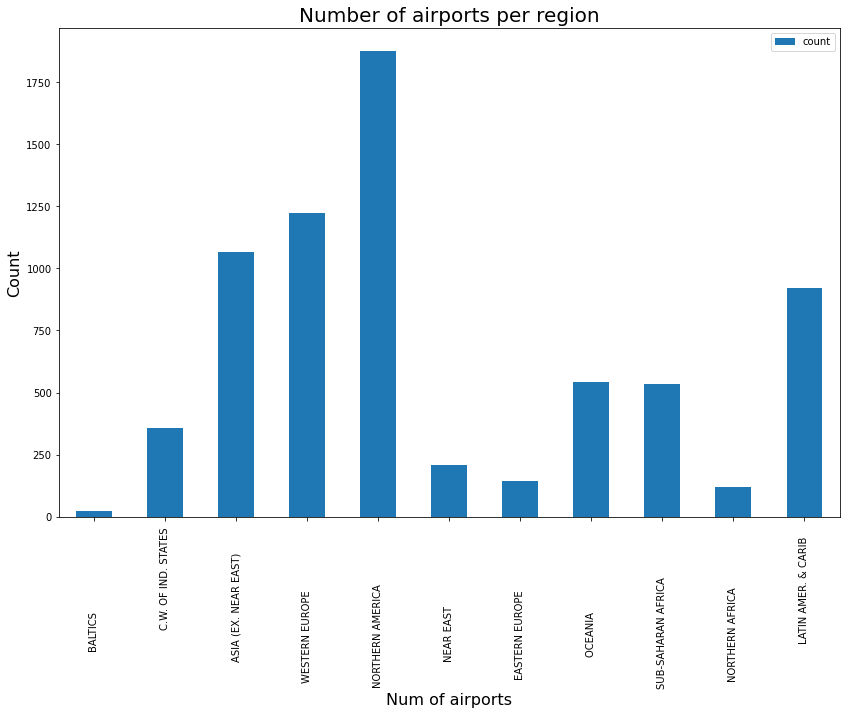

In [ ]:
count_by_region_df.toPandas().plot.bar(x='Region', y='count', figsize=(14, 9))
plt.title('Number of airports per region', fontsize=20)
plt.xlabel('Num of airports', fontsize=16)
plt.ylabel('Count', fontsize=16)


plt.show()